In [1]:
import os
image_path = "../dataset/pizza_steak_sushi/"

train_dir = os.path.join(image_path, "train")
test_dir = os.path.join(image_path, "test")

In [2]:
from torchvision import transforms
from data_setup import createDataloader

train_transform = transforms.Compose(
    [   
        transforms.Resize((224, 224)) ,
        transforms.ToTensor()

    ]
)

train_DL, test_DL, _classes = createDataloader(train_dir, test_dir, 32, train_transform, train_transform )

In [3]:
len(train_DL)

8

In [4]:
_classes

['pizza', 'steak', 'sushi']

6


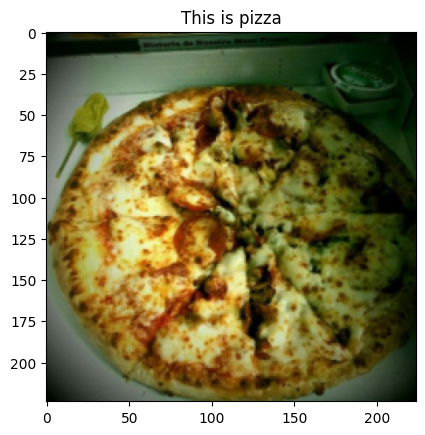

In [5]:
# data visuals
import  matplotlib.pyplot as plt
from PIL import Image
import random

img, lable = next(iter(test_DL))

rand_id = random.randint(0,31)
print(rand_id)

show_img = img[rand_id]
plt.title("This is {}".format(_classes[lable[rand_id]]))
plt.imshow(show_img.permute(1,2,0))

# Replicating ViT

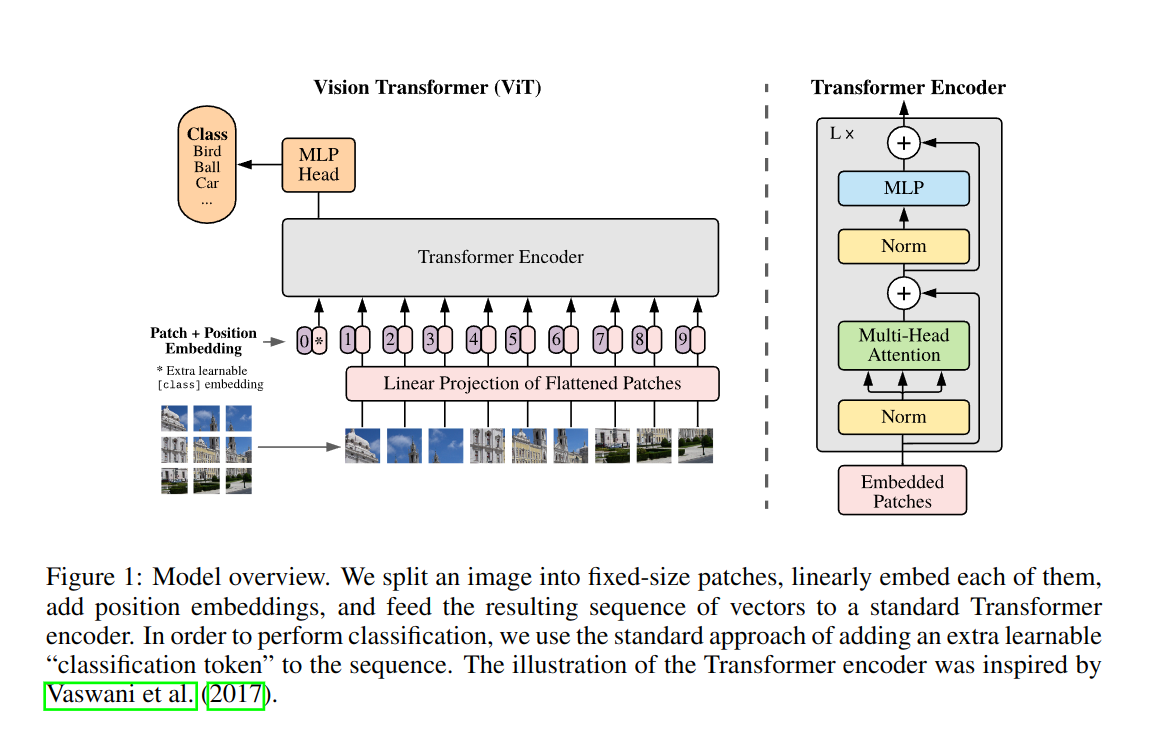

### Embedding - Leaning representations, start from a random initialization and improve them through training.
    - 1D vector will be input to the model


##### * Equation 1
```python
x_input = [class_token, image_patch1, image_patch2,.. image_patchN] + [class_token_pos, image_patch1_pos, image_patch2_pos,.. image_patchN_pos]
```

##### * Equation 2
```python
x_MSA_output = MultiHSA(LayerNorm(x_input)) + x_input
```

##### * Equation 3
```python
x_MLP_output = MLP(LayerNorm(x_MSA_output)) + x_MSA_output
```

<b>MLP - Multi Layer Perceptron (a nn with multiple layers)</b>

##### Equation 4 - Output
```python
x_output = LinearLayer(LayerNorm(x_MLP_output))
```

## Patch position and class Embeding

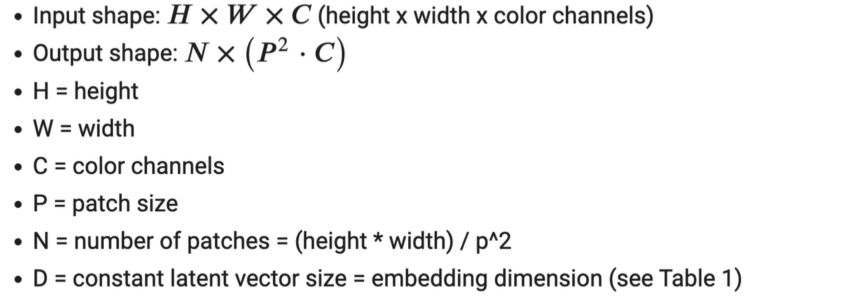

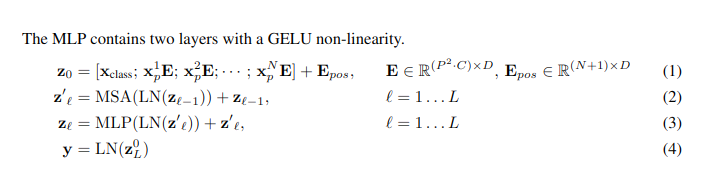

In [6]:
H = 224
W = 224
C = 3
P = 16
N = int((H * W) / P**2)
N

196

In [7]:
embbeding_inp_shape = (H,W,C)
embbeding_out_shape = (N , (P**2) * C)


print("Input Shape:",embbeding_inp_shape)
print("Output Shape:",embbeding_out_shape, "(Number of patches, embedding size)")


Input Shape: (224, 224, 3)
Output Shape: (196, 768) (Number of patches, embedding size)


In [8]:
# turing image to patch

In [9]:
# Ploting first dim of the image
img[0][:,:1,:].shape

torch.Size([3, 1, 224])

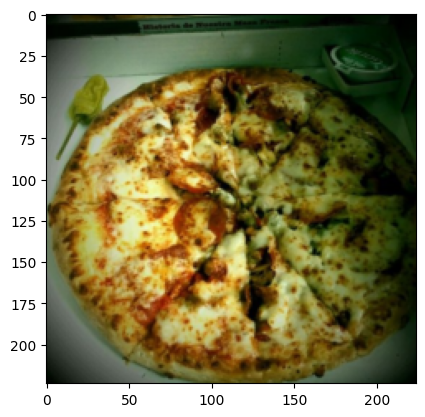

In [10]:
plt.imshow(img[rand_id].permute(1,2,0))

In [11]:
img_size = 224
patch_size = 16

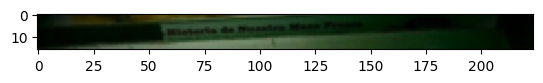

In [12]:
plt.imshow(img[rand_id][:,:patch_size,:].permute(1,2,0))

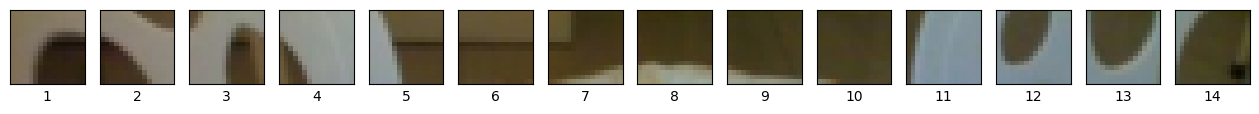

In [13]:

num_patches = img_size // patch_size
assert img_size % patch_size == 0, "image size is not exactly divisible"
# plt.imshow(img[0][:,:patch_size,:patch_size].permute(1,2,0))

fig, axs = plt.subplots(nrows=1, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

# iter ver a pactch
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(img[0][:,:patch_size,patch:patch+patch_size].permute(1,2,0))
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

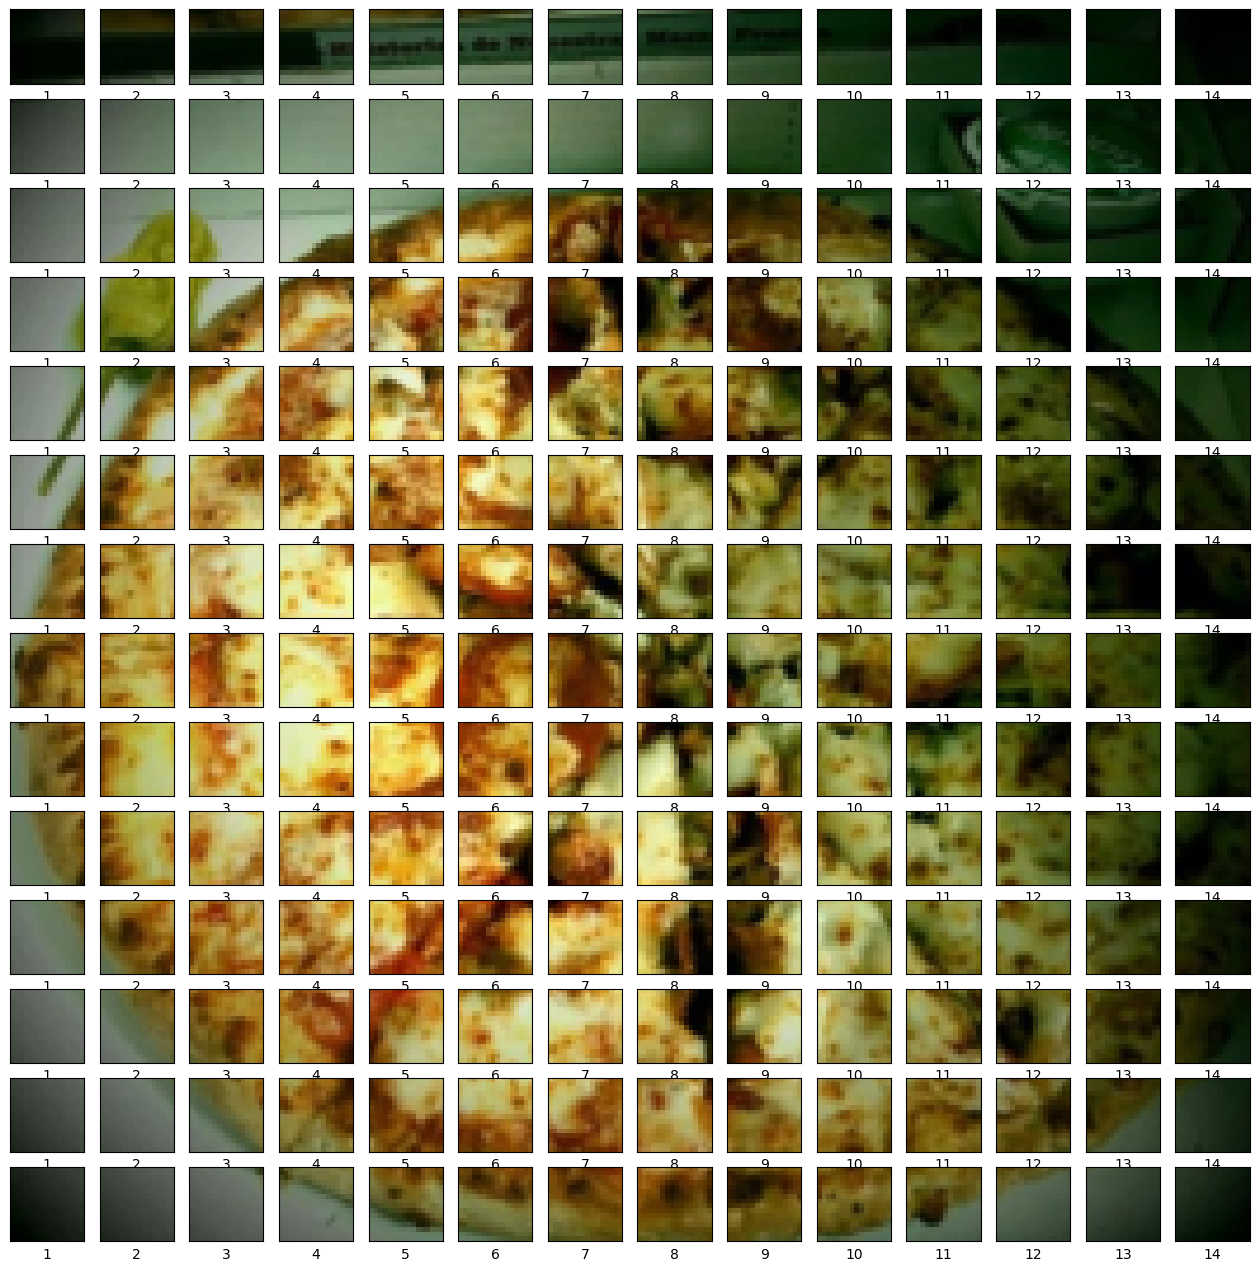

In [14]:
## ploting whole image as a patch

img_size = 224
patch_size = 16

num_patches = img_size // patch_size
assert img_size % patch_size == 0, "image size is not exactly divisible"
# plt.imshow(img[0][:,:patch_size,:patch_size].permute(1,2,0))

fig, axs = plt.subplots(nrows=img_size//patch_size, ncols=img_size//patch_size, sharex=True, sharey=True, figsize=(patch_size, patch_size))

for j, patch_j in enumerate(range(0, img_size, patch_size)):
    for i, patch_i in enumerate(range(0, img_size, patch_size)):
        axs[j,i].imshow(img[rand_id][:,patch_j:patch_j+patch_size,patch_i:patch_i+patch_size].permute(1,2,0))
        axs[j,i].set_xlabel(i+1)
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])

In [15]:
# applying conv2d to cut into patches

from torch import nn

conv2D = nn.Conv2d(in_channels=3,out_channels=768, # 768 from paper ((P**2) * C)
                   stride=patch_size, kernel_size=patch_size, padding=0)

In [16]:
conv2D

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [17]:
img[0].squeeze(0).shape

torch.Size([3, 224, 224])

In [18]:
patched_img = conv2D(img.squeeze(0))
patched_img.shape

torch.Size([32, 768, 14, 14])

In [19]:
conv2D(img.squeeze(0)).shape

torch.Size([32, 768, 14, 14])

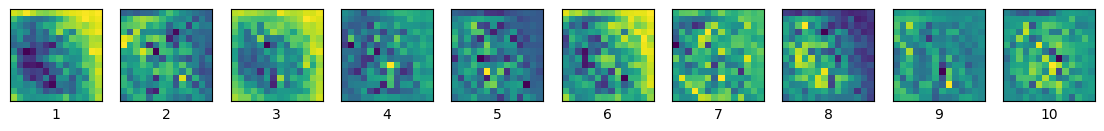

In [20]:
# visulizing feature map

fig, axs = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True, figsize=(14,14))

conv2d_out = conv2D(img[rand_id])

for i in range(0,10):
    tmp_rand = random.randint(0, 768)

    axs[i].imshow(conv2d_out[tmp_rand].detach().numpy())
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [21]:
flat = nn.Flatten(start_dim=2, end_dim=3)
flat_img_conv = flat(patched_img)
# plt.imshow(flat(patched_img)[0])

In [22]:
#rearranging flattern dim
flat_img_conv.permute(0,2,1).shape

torch.Size([32, 196, 768])

In [23]:
flat_img_conv[:,:,0].shape

torch.Size([32, 768])

In [24]:
# img to patch embedding layer (img to pacth embedding)

# pacth_size = 16

# img_to_seq = nn.Sequential(
#     nn.Conv2d(3, 768, patch_size, patch_size, padding=0),
#     nn.Flatten(start_dim=2, end_dim=3)
# )

# img_size(img)

class PatchEmbedding(nn.Module):
    def __init__(self, color_channel, num_patch, patch_size):
        super().__init__()
        self.conv_layer = nn.Conv2d(in_channels=color_channel, 
                               out_channels=num_patch,
                               kernel_size=patch_size,
                               stride=patch_size, 
                               padding=0)
        self.flat = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x = self.conv_layer(x)
        return self.flat(x).permute(0,2,1) # batch, number_of_patch, embedding_dim

pe = PatchEmbedding(3, 768, 16)
print(img.shape)
patch_embb_img = pe(img)



torch.Size([32, 3, 224, 224])


In [25]:
patch_embb_img.shape

torch.Size([32, 196, 768])

In [26]:
batch_size = patch_embb_img.shape[0]
embb_dim = patch_embb_img.shape[-1]

batch_size, embb_dim

(32, 768)

In [45]:
# class token embbb as learnable param
import torch

class_token = nn.Parameter(torch.randn(batch_size, 1, embb_dim), requires_grad=True)
class_token.shape

torch.Size([32, 1, 768])

In [46]:
# adding class token to embeedidng

patch_embbed_with_class_embbed = torch.cat((class_token, patch_embb_img), dim=1)
patch_embbed_with_class_embbed, patch_embbed_with_class_embbed.shape

(tensor([[[-1.1246e+00,  1.3615e-01, -9.4102e-01,  ..., -8.6426e-01,
           -1.6110e+00,  1.7344e+00],
          [ 1.6182e-01, -4.5356e-01, -5.6640e-02,  ...,  2.8615e-01,
            6.2881e-02, -2.1412e-01],
          [ 8.2349e-02, -4.4222e-01, -2.8283e-01,  ...,  3.4988e-01,
            5.8159e-02, -3.4970e-01],
          ...,
          [ 4.7826e-01, -7.5909e-01, -2.9767e-01,  ...,  7.8233e-01,
            1.3594e-01, -4.9611e-01],
          [ 5.6207e-01, -8.2427e-01, -3.5454e-01,  ...,  8.3226e-01,
            1.4214e-01, -5.5116e-01],
          [ 5.5191e-01, -8.4452e-01, -3.6552e-01,  ...,  8.1224e-01,
            1.4462e-01, -5.6768e-01]],
 
         [[ 6.5476e-01, -6.8347e-01, -7.8610e-01,  ..., -1.9286e+00,
           -4.0629e-01,  1.1821e+00],
          [ 4.8883e-01, -8.3566e-01, -3.7169e-01,  ...,  6.4454e-01,
            2.9658e-01, -6.5825e-01],
          [ 4.7031e-01, -8.1971e-01, -3.7955e-01,  ...,  6.3420e-01,
            2.6392e-01, -6.2999e-01],
          ...,
    

In [56]:
H, W, patch_size

(224, 224, 16)

In [58]:
num_of_patchs = int((H*W) / patch_size**2)

position_embbeding = nn.Parameter(torch.ones(batch_size, 1+num_of_patchs, embb_dim), requires_grad=True)
print(position_embbeding.shape)

torch.Size([32, 197, 768])


In [62]:
# adding patch_embbed_with_class_embbed and position_embbeding
torch.add(patch_embbed_with_class_embbed, position_embbeding).shape

torch.Size([32, 197, 768])

In [ ]:
#adding